In [170]:
from pylab import *
import h5py
from scipy.optimize import curve_fit
#from scipy.stats import binned_statistic_dd
from scipy.stats import binned_statistic_dd
import filter_masks
import pickle
from scipy import stats

In [171]:
#load data
experiment_run_name = "sxri0414run81"
my_file = experiment_run_name+".h5"
my_hdf5_object = h5py.File("../small_h5_data/"+my_file,"r")

In [172]:
#convert hdf5 to dict
my_list = []
def func(name, obj):
    my_list.append(name)

my_hdf5_object.visititems(func)
my_dict = {}
for i in my_list:
    my_dict[i] = array(my_hdf5_object[i])
pixel_to_femtosecond_list = []
width_list = []

In [173]:
try:
    last_results = my_results.copy()
except:
    pass
#configuration parameters
time_tool_sign = 1
#pixel_to_femtosecond = 0.0033444
pixel_to_femtosecond = 0.0034
delay_stage_offset = min(my_dict['delayStage'])

In [174]:
#subplot(121)
#hist(my_dict['timeToolOpal/time_pixel'],bins=arange(0,600,6))
#subplot(122)
#plot(my_dict['ebeam/photon_energy'],my_dict['GMD'],'.')
#xlim(900,930)
#show()

In [175]:
#make mask
my_mask =  filter_masks.__dict__[experiment_run_name](my_dict)
my_mask *=  (my_dict['timeToolOpal/time_pixel']>300)
my_mask *=  (my_dict['timeToolOpal/time_pixel']<1600)
#my_mask *=  (my_dict['ebeam/photon_energy']<925)
#my_mask *=  (my_dict['ebeam/photon_energy']>910)
#my_mask *=  (my_dict['timeToolOpal/uncertainty_cov']*pixel_to_femtosecond<0.0002)

/reg/data/ana13/sxr/sxri0414/res/automated_analysis/jupyter_notebooks/filter_masks.py:107: RuntimeWarning: invalid value encountered in greater
  myMask = myMask * (array(myDict['gas_detector/f_11_ENRC'])>0.3)


In [176]:
#TSS_OPAL/pixelTime = is the original psana type analyzed time tool data
#timeToolOpal/time_pixel = this is the custom analyzed time tool data using eigen backgrounds
#my_dict['corrected_time'] = (2/.3*(my_dict['delayStage']-delay_stage_offset)+time_tool_sign*(my_dict['TSS_OPAL/pixelTime']-mean(my_dict['TSS_OPAL/pixelTime'][my_mask]))*pixel_to_femtosecond )
my_dict['corrected_time'] = (2/.3*(my_dict['delayStage']-delay_stage_offset)+time_tool_sign*(my_dict['timeToolOpal/time_pixel']-mean(my_dict['timeToolOpal/time_pixel'][my_mask]))*pixel_to_femtosecond )

In [177]:
#subplot(121)
#plot(my_dict['GMD'][my_mask],my_dict['acqiris2/amplitude'][my_mask],'.')
#ylim(-0.1,1)
#subplot(122)
#hist(my_dict['TSS_OPAL/pixelTime'][my_mask]*pixel_to_femtosecond,bins=arange(0.6,2.0,0.001))
#show()

In [178]:
#subplot(121)
#hist(abs(my_dict['timeToolOpal/uncertainty_cov'])**0.5,bins=arange(-0.1,1,0.01))
#subplot(122)
#hist(abs(my_dict['timeToolOpal/time_pixel']),bins=arange(200,550,4))
#show()

In [179]:
#putting data into shorter variables cause I'm tired of typing
x = my_dict['GMD'][my_mask]
y = my_dict['acqiris2/amplitude'][my_mask]
sy = my_dict['acqiris2/uncertainty_cov'][my_mask]
z = my_dict['corrected_time'][my_mask]
myValues = array([x,y,z,sy]).transpose()
my_bins = arange(-6.0,35,0.15)

#defining truncated mean
def quartile_mean(x):
    return stats.trim_mean(x, 0.25)

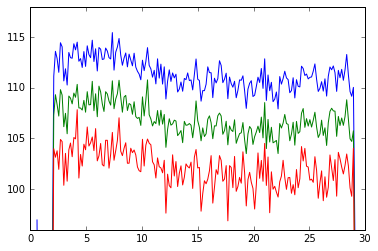

In [180]:
#removing the vectorized custom binned statistic and replacing with supported one
#first one below is the unweighted average
binned_acqiris = binned_statistic_dd(z,y,bins=[my_bins],statistic=average)
binned_GMD = binned_statistic_dd(z,x,bins=[my_bins],statistic=average)
plot(my_bins[:-1],(binned_acqiris.statistic/binned_GMD.statistic)[::-1]+4)

#the one below is the weighted average
binned_weighted_acqiris = binned_statistic_dd(z,y/sy,bins=[my_bins],statistic=average)
binned_weights = binned_statistic_dd(z,1.0/sy,bins=[my_bins],statistic=average)
binned_GMD = binned_statistic_dd(z,x,bins=[my_bins],statistic=average)
plot(my_bins[:-1],(binned_weighted_acqiris.statistic/binned_weights.statistic/binned_GMD.statistic)[::-1])

#the one below is the trunctated mean
binned_acqiris = binned_statistic_dd(z,y,bins=[my_bins],statistic=quartile_mean)
binned_GMD = binned_statistic_dd(z,x,bins=[my_bins],statistic=quartile_mean)
plot(my_bins[:-1],(binned_acqiris.statistic/binned_GMD.statistic)[::-1]-6)

ylim(96,118)
show()


In [181]:
#one of the problems with binning is that points falling at the edge of only contribue to the bin they fall into. 
#This section adds a weighting for the distance from the bin edge. if a point falls on the edge of the bin, 
#it contributes only marginally to that bin and majority to the other bin

def weighted_binned_statistic(x,y,weights,bins,statistic):
    binned_weighted_statistic = binned_statistic_dd(x,y*weights,bins=[my_bins],statistic=average)
    binned_weights = binned_statistic_dd(x,1.0*weights,bins=[my_bins],statistic=average)
    
    return  binned_weighted_statistic.statistic/binned_weights.statistic

def binned_statistic_edge_corrected(x,y,sy,bins,statistic):
    #calculate two binned statistics
    bin_size = mean(diff(my_bins))
    bin_axis_weighting1 = (x%bin_size)
    
    #binned_data1 = weighted_binned_statistic(x,y,1.0/sy,bins,statistic)
    #binned_data2 = weighted_binned_statistic(x,y,1.0/sy,bins,statistic)
    
    #binned_data1 = weighted_binned_statistic(x,y,bin_axis_weighting1,bins,statistic)
    #binned_data2 = weighted_binned_statistic(x,y,(bin_size-bin_axis_weighting1),bins,statistic)
    
    binned_data1 = weighted_binned_statistic(x,y,1.0/sy*bin_axis_weighting1,bins,statistic)
    binned_data2 = weighted_binned_statistic(x+1*bin_size,y,1.0/sy*(bin_size-bin_axis_weighting1),bins,statistic)
    #is the shift on x in the line immediately above correct?
  
    return (binned_data1+binned_data2)/2
    

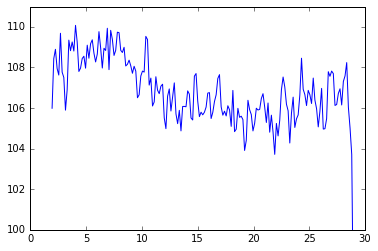

In [182]:
edge_corrected_data = binned_statistic_edge_corrected(z,y,sy,bins=[my_bins],statistic=average)/binned_statistic_edge_corrected(z,x,ones(len(x)),bins=[my_bins],statistic=average)
plot(my_bins[:-1],edge_corrected_data[::-1])
ylim(100,111)
show()

In [183]:
#make I vs I0 calibration
xScatter = my_dict['GMD'][my_mask]
yScatter = my_dict['acqiris2/amplitude'][my_mask]
dxScatter = my_dict['acqiris2/uncertainty_cov'][my_mask]
maxXScatter = max(xScatter)
myBins = arange(-5,maxXScatter,0.000010)
y,x = histogram(xScatter,myBins,weights = yScatter )
nonZeroMask = (y!=0)
y/=(histogram(xScatter,myBins)[0])+1e-9
x = x[nonZeroMask]
y = y[nonZeroMask]
#myFit = polyfit(x,y,4)
myFit = polyfit(append(x,zeros(1e6)),append(y,zeros(1e6)),3)
p = poly1d(myFit)
def func(x,a):
    return p(a*x)

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 500200 but corresponding boolean dimension is 500199
/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [184]:
def fitMyData(binStart,binEnd):

    binStep = binEnd-binStart
    timeMask = my_dict['corrected_time'][my_mask]>binStart 
    timeMask *= my_dict['corrected_time'][my_mask]<binEnd
    xdata = my_dict['GMD'][my_mask][timeMask]
    ydata = my_dict['acqiris2/amplitude'][my_mask][timeMask]
    dxdata = my_dict['acqiris2/uncertainty_cov'][my_mask][timeMask]
    tdata = my_dict['corrected_time'][my_mask][timeMask]
    
   
 

    myLength = len(ydata)
    #remove outliers
    #outlier threshold is 20%
    threshold = 0.01/4
    try:
        #threshold = 10.0/(myLength)
        temp=1
    except ZeroDivisionError:
        return -999,-999

    ySortedIndex = argsort(ydata)
    ydata = ydata[ySortedIndex][int(threshold*myLength):int(myLength*(1-1*threshold))]
    xdata = xdata[ySortedIndex][int(threshold*myLength):int(myLength*(1-1*threshold))]
    tdata = tdata[ySortedIndex][int(threshold*myLength):int(myLength*(1-1*threshold))]
    dxdata = dxdata[ySortedIndex][int(threshold*myLength):int(myLength*(1-1*threshold))]

    xSortedIndex = argsort(xdata)
    ydata = ydata[xSortedIndex][int(threshold*myLength):int(myLength*(1-1*threshold))]
    xdata = xdata[xSortedIndex][int(threshold*myLength):int(myLength*(1-1*threshold))]
    tdata = tdata[xSortedIndex][int(threshold*myLength):int(myLength*(1-1*threshold))]
    dxdata = dxdata[xSortedIndex][int(threshold*myLength):int(myLength*(1-1*threshold))]
    #plot(xdata,ydata,'.')

    #popt, pcov = curve_fit(func, xdata, ydata,p0=1)
    #mySigma = (dxdata+binStep/(binStep+tdata-binStart))**0.5 # equals one if tdata is binStart and
    #print(str(mySigma.shape)+","+str(timeMask.shape)+", "+str(tdata.shape)+", "+ str(xdata.shape)+", "+str(dxdata.shape)+str(ydata.shape))
    #popt, pcov = curve_fit(func, xdata, ydata,p0=1,sigma=mySigma)
    try:
        #mySigma accounts for some data being closer to bin edge by weighting which bin it goes into
        #mySigma = (dxdata*binStep/(binStep+tdata-binStart))**0.5 # equals one if tdata is binStart and
        mySigma = dxdata
        popt, pcov = curve_fit(func, xdata, ydata,p0=1,sigma=mySigma)
        #popt, pcov = curve_fit(func, xdata, ydata,p0=1)
        #print(popt)
    except:
        popt,pcov = [-999],[[-999]]

    if popt[0]!=-999:
        #IPython.embed()
        temp = 1

    #IPython.embed()
    return popt[0],pcov[0][0]*len(tdata)**0.5

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


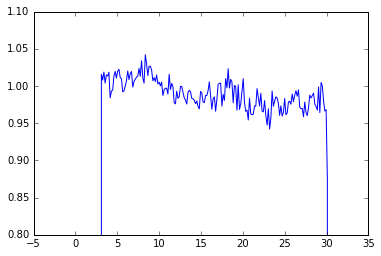

In [185]:
binStart= -5.00
binSize = mean(diff(my_bins))
myBins = arange(binStart,35,binSize)
myDelayTrace = array([fitMyData(i,i+binSize) for i in myBins])
plot(myBins[::-1],myDelayTrace[:,0])
ylim(0.80,1.1)
xlim
show()

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


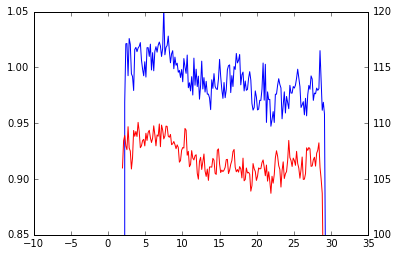

In [186]:
binStart= -1.00
binSize = mean(diff(my_bins))
myBins = 0+my_bins
myDelayTrace = array([fitMyData(i,i+binSize) for i in myBins])
plot(myBins[::-1],myDelayTrace[:,0])
ylim(0.85,1.05) 
twinx()
plot(my_bins[:-1],edge_corrected_data[::-1],'r-')
ylim(100,120)
show()